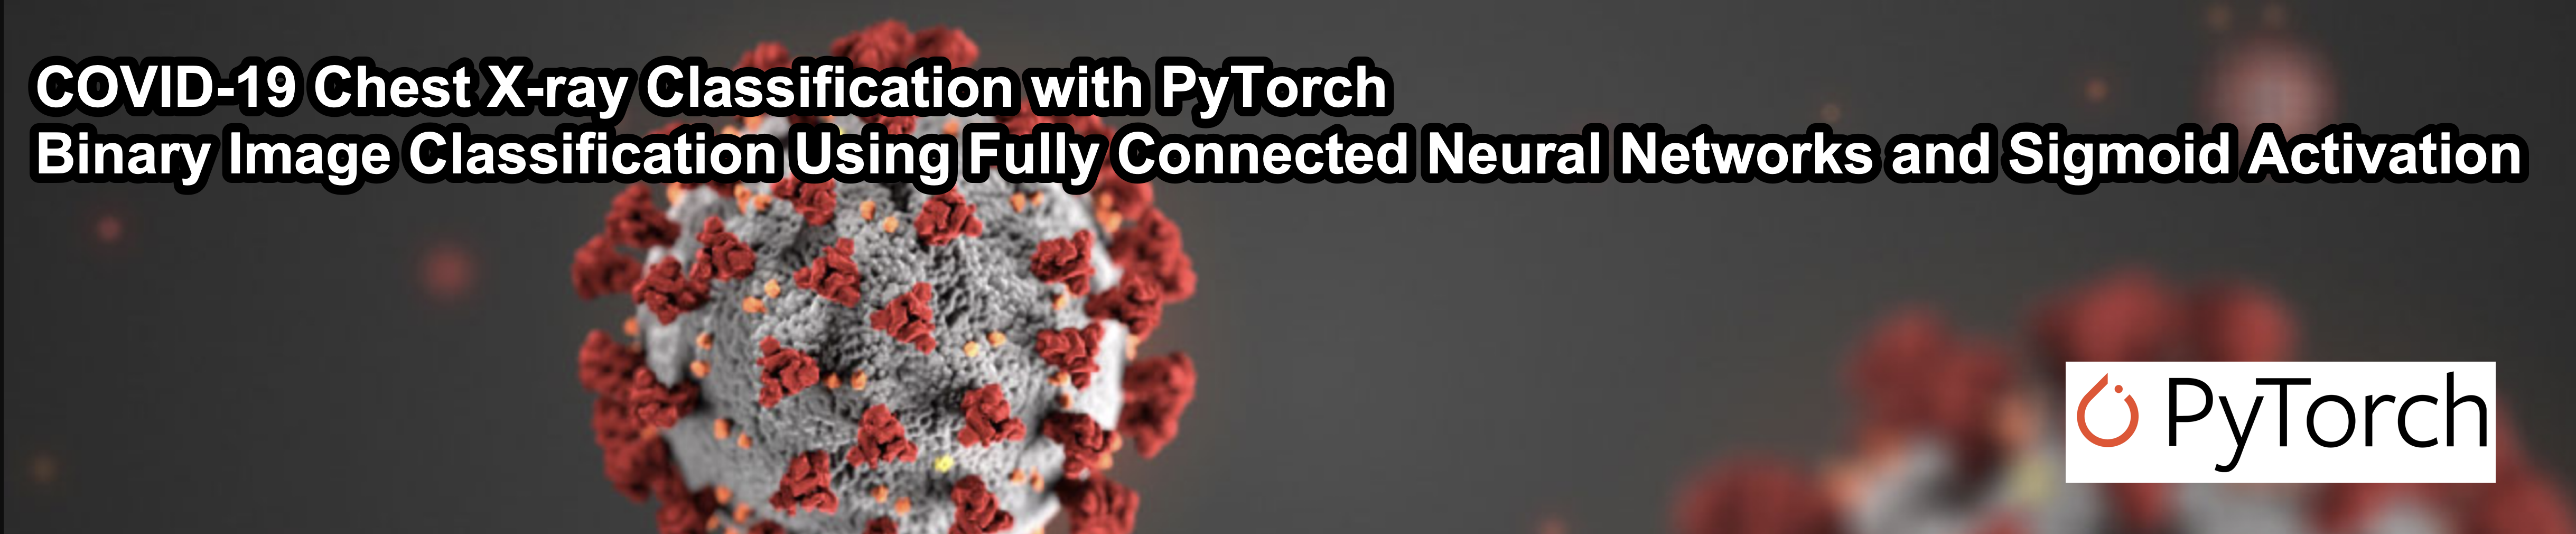

# COVID-19 Chest-X-Ray Classifier (PyTorch)

1. Load images, convert to RGB, resize to **224 × 224**, scale 0-1  
2. Binary-encode labels (`covid19` = 1, `no_covid19` = 0)  
3. 80 / 20 split → train / test, then 80 / 20 train → validation  
4. Tensors + `DataLoader`s  
5. FC network: *Flatten → 300 → 200 → 1 (sigmoid)*  
6. Train **70 epochs** (BCE + SGD) and chart accuracy / loss  
7. Final test-set evaluation

## 1.  Imports & Environment
Import scientific-Python, OpenCV, PyTorch, and utility libraries; set the `device` (CPU / GPU).

In [10]:
from pathlib import Path
from imutils import paths
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [44]:
# Optional: use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 2.  Dataset Path & Initialisation
Define the dataset root and collect all image file paths for subsequent processing.

In [47]:
# Setting the dataset paths
dataset = "datasets/"

## 3.  Load, Convert, and Resize Images

* Read each image.  
* Convert BGR → RGB.  
* Resize to **224 × 224** (ignoring aspect ratio) so every sample has the same spatial dimensions.

In [50]:
# Look over the images in our dataset and then initialize our data & labels
imagePaths = list(paths.list_images(dataset))
data   = []
labels = []

for imagePath in imagePaths:
    # Extract class label from the file path (covid19 | no_covid19)
    label = imagePath.split(os.path.sep)[-2]
    
    # Load → BGR→RGB → resize 224×224 (ignore aspect)
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    data.append(image)
    labels.append(label)

# Convert to NumPy and scale pixel intensities to [0, 1]
data   = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

print(labels[:10])  # sanity-check

['covid19' 'covid19' 'covid19' 'covid19' 'covid19' 'covid19' 'covid19'
 'covid19' 'covid19' 'covid19']


## 4.  Visual Sanity Checks
Display a couple of random images with their labels to confirm the loader works and class folders are correct.

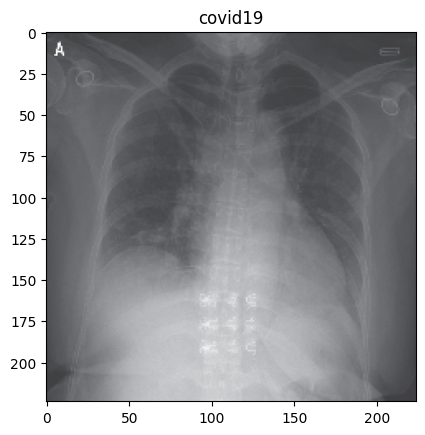

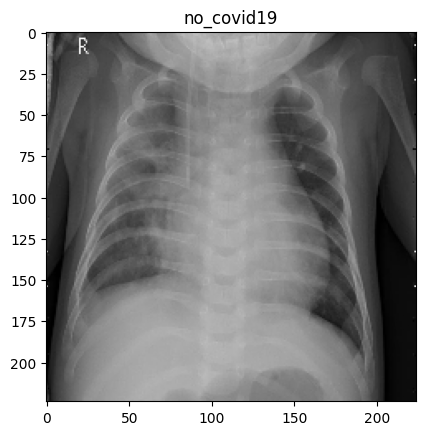

Single sample shape: (224, 224, 3)
Dataset shape      : (50, 224, 224, 3)


In [52]:
# Visual sanity-check (identical to original)
plt.title(labels[1])
plt.grid(False)
plt.imshow(data[1]); plt.show()

plt.title(labels[27])
plt.grid(False)
plt.imshow(data[27]); plt.show()

print("Single sample shape:", data[27].shape)
print("Dataset shape      :", data.shape)

## 5.  Label Encoding (Binary)

Convert the string labels (`covid19`, `no_covid19`) into **binary 0/1** targets for the sigmoid output layer.


In [56]:
labels_enc = (labels == "covid19").astype("float32")  # 1 for covid19 else 0
print(labels_enc[:10])


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 6.  Train / Validation / Test Split

* 80 % training data, 20 % hold-out test set (`random_state=42`).  
* Further split the training partition 80 / 20 into training and validation sets.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels_enc, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.20, random_state=42)

print("Train shape:", X_train.shape)
print("Val   shape:", X_val.shape)
print("Test  shape:", X_test.shape)

Train shape: (32, 224, 224, 3)
Val   shape: (8, 224, 224, 3)
Test  shape: (10, 224, 224, 3)


## 7.  Torch Tensor Conversion & DataLoaders

Transform NumPy arrays → PyTorch tensors (NCHW) and wrap them in `DataLoader`s for efficient minibatching.

In [62]:
batch_size = 32

def make_loader(features, targets, shuffle=False):
    tensor_x = torch.tensor(features).permute(0, 3, 1, 2)  # NHWC → NCHW
    tensor_y = torch.tensor(targets).unsqueeze(1)          # (N,1)
    ds = TensorDataset(tensor_x, tensor_y)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train, y_train, shuffle=True)
val_loader   = make_loader(X_val,   y_val)
test_loader  = make_loader(X_test,  y_test)


## 8.  Fully-Connected Classifier Architecture

`` Flatten → Dense (300) → ReLU → Dense (200) → ReLU → Dense (1) → Sigmoid ``  
Matches the original Keras model **exactly**.

In [65]:
model2 = nn.Sequential(
    nn.Flatten(),                               # (N, 3*224*224)
    nn.Linear(224 * 224 * 3, 300),
    nn.ReLU(inplace=True),
    nn.Linear(300, 200),
    nn.ReLU(inplace=True),
    nn.Linear(200, 1),
    nn.Sigmoid()                                # match Keras 'sigmoid'
).to(device)

print(model2)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=300, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=300, out_features=200, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=200, out_features=1, bias=True)
  (6): Sigmoid()
)


## 9.  Loss Function, Optimiser, & Metrics

* **Binary Cross-Entropy** (`nn.BCELoss`)  
* **Stochastic Gradient Descent** with default momentum & `lr=0.01`  
* Accuracy computed per epoch for both train and validation splits.

In [67]:
criterion = nn.BCELoss()              # binary_crossentropy equivalent
optimizer = optim.SGD(model2.parameters(), lr=0.01)


## 10.  Training Loop

Iterate over `train_loader`, back-propagate, validate on `val_loader`, and log loss/accuracy each epoch.

In [69]:
num_epochs = 70
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}

for epoch in range(1, num_epochs + 1):
    # ---- training ----
    model2.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model2(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
        preds = (outputs >= 0.5).float()
        running_correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc  = running_correct / total
    
    # ---- validation ----
    model2.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model2(X_batch)
            loss = criterion(outputs, y_batch)
            
            val_loss += loss.item() * X_batch.size(0)
            preds = (outputs >= 0.5).float()
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)
    
    val_loss /= val_total
    val_acc  = val_correct / val_total
    
    # Log metrics
    history["loss"].append(epoch_loss)
    history["val_loss"].append(val_loss)
    history["accuracy"].append(epoch_acc)
    history["val_accuracy"].append(val_acc)
    
    print(f"Epoch {epoch:03d}/{num_epochs} "
          f"- loss: {epoch_loss:.4f} acc: {epoch_acc:.4f} "
          f"- val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}")


Epoch 001/70 - loss: 0.6925 acc: 0.5312 - val_loss: 0.5954 val_acc: 0.6250
Epoch 002/70 - loss: 0.6550 acc: 0.5312 - val_loss: 0.7139 val_acc: 0.3750
Epoch 003/70 - loss: 0.6816 acc: 0.4688 - val_loss: 0.5638 val_acc: 0.6250
Epoch 004/70 - loss: 0.6739 acc: 0.5312 - val_loss: 0.7119 val_acc: 0.3750
Epoch 005/70 - loss: 0.6747 acc: 0.4688 - val_loss: 0.5467 val_acc: 0.6250
Epoch 006/70 - loss: 0.6270 acc: 0.5312 - val_loss: 0.5661 val_acc: 1.0000
Epoch 007/70 - loss: 0.5906 acc: 0.8750 - val_loss: 0.4722 val_acc: 0.7500
Epoch 008/70 - loss: 0.5735 acc: 0.6250 - val_loss: 0.6510 val_acc: 0.3750
Epoch 009/70 - loss: 0.6326 acc: 0.5000 - val_loss: 0.5240 val_acc: 0.6250
Epoch 010/70 - loss: 0.7054 acc: 0.5312 - val_loss: 0.7061 val_acc: 0.3750
Epoch 011/70 - loss: 0.6657 acc: 0.4688 - val_loss: 0.4365 val_acc: 0.6250
Epoch 012/70 - loss: 0.5587 acc: 0.6250 - val_loss: 0.4496 val_acc: 1.0000
Epoch 013/70 - loss: 0.5041 acc: 0.9062 - val_loss: 0.3439 val_acc: 0.8750
Epoch 014/70 - loss: 0.49

## 11.  Training History Plot

Plot the evolution of `loss`, `val_loss`, `accuracy`, and `val_accuracy` to visualise convergence and potential overfitting.

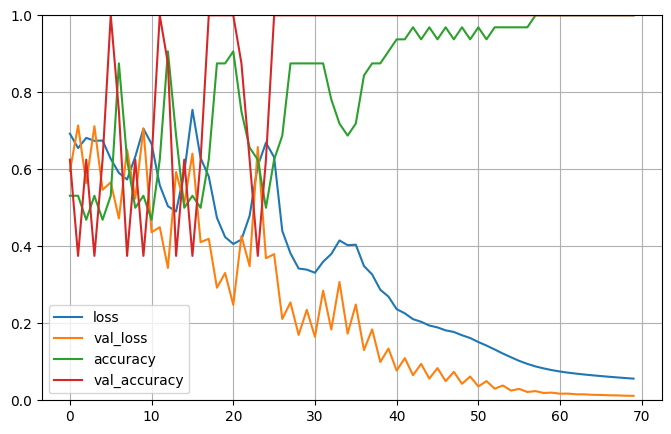

In [71]:
pd.DataFrame(history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


## 12.  Final Evaluation on Test Set

Compute test loss and accuracy using the **unseen 20 %** hold-out data to quantify generalisation.

In [81]:
model2.eval

<bound method Module.eval of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=300, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=300, out_features=200, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=200, out_features=1, bias=True)
  (6): Sigmoid()
)>

In [83]:
def evaluate(model, loader, criterion, threshold=0.5):
    model.eval()
    loss_sum = correct = total = 0

    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)

            loss_sum += criterion(out, y).item() * y.size(0)
            correct  += (out >= threshold).eq(y).sum().item()
            total    += y.size(0)

    return loss_sum / total, correct / total


# ---- run on the test set ----
test_loss, test_acc = evaluate(model2, test_loader, criterion)
print(f"\nTest loss: {test_loss:.4f}  |  Test accuracy: {test_acc:.4f}")


Test loss: 0.0321  |  Test accuracy: 1.0000


----

## Comparison between TF/Keras and PyTorch

Keras behaves like an automatic car. You can start driving immediately with very few controls. PyTorch is a manual car. One extra action to get going, but every knob and pedal is under your control.

* **Model building**  
  In Keras you declare a `Sequential` model and let it figure out most shapes for you. PyTorch uses the same `nn.Sequential` syntax, but you must spell out the exact input size for every layer. It takes one extra moment, but you always know what tensor shape is flowing through the network.

* **Starting the training loop**  
  Keras hides everything behind a single call to `model.fit()`. You never see gradients, optimisers, or batches—training just rolls. In PyTorch you write a loop yourself: run a forward pass, calculate the loss, call `loss.backward()`, and then `optimizer.step()`. It is a handful of extra lines, but the trade-off is total freedom to change anything later on (mixed precision, gradient clipping, fancy schedulers).

* **Feeding data**  
  Handing data to Keras is effortless; you throw in NumPy arrays and Keras handles shuffling and batching under the hood. PyTorch asks you to wrap those arrays in a `TensorDataset` and `DataLoader`, and you flip the channel order from NHWC to NCHW once. After that, loading is automatic. You write slightly more code but gain direct control over batch size, workers, and on-the-fly transforms.

* **Moving to the GPU**  
  Keras slips the tensors onto the GPU for you. In PyTorch you make it explicit `model.to(device)` and `batch.to(device)` inside the loop. 

* **Logging accuracy and loss**  
  Keras collects metrics for every epoch and hands you a neat `History` object. With PyTorch you append numbers to a plain Python dictionary.

* **Evaluation on the test set**  
  Keras gives you `model.evaluate()`. In PyTorch you write a 10-line helper wrapped in `torch.no_grad()`.